In [12]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.neighbors import DistanceMetric
from math import radians
import folium
from folium import plugins
import ipywidgets
import geopy
import numpy as np
import pandas as pd
from vega_datasets import data as vds
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
import openpyxl




# Junho


 Faltam os dias 3, 4, 5, 6, 12, 19, 26, 27

In [13]:
junho = pd.read_csv("Dados brutos/passengers_junho.csv",
                    index_col= 'Unnamed: 0')

    #  Sao 214k linhas

In [14]:
junho

,device_id,timestampI,timestampF,MAC,RSSI,channel,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,id,duration
0,617.0,1622529842,1622529920,40:06:a0:5b:8c:b2,-45,11,-22.827145,-47.061214,-22.829490,-47.060281,40,0,78
1,617.0,1622529842,1622529920,0c:ef:af:d3:00:36,-65,11,-22.827145,-47.061214,-22.829490,-47.060281,15,1,78
2,617.0,1622529847,1622529875,24:fd:0d:bd:91:49,-67,6,-22.826890,-47.061367,-22.826994,-47.061368,3,2,28
3,617.0,1622529850,1622529850,0e:ec:8d:d0:6d:0d,-90,7,-22.826730,-47.061454,-22.826730,-47.061454,2,3,0
4,617.0,1622529856,1622529856,0a:cc:27:40:31:3c,-87,4,-22.826406,-47.061626,-22.826406,-47.061626,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214541,NaN,1625079190,1625079190,22:ae:9f:77:09:55,-85,1,-22.816560,-47.072811,-22.816560,-47.072811,1,524,0
214542,NaN,1625079193,1625079196,50:92:b9:3b:a7:2a,-91,11,-22.816561,-47.072812,-22.816566,-47.072808,3,525,3
214543,NaN,1625079121,1625079121,ae:30:5e:57:df:56,-88,6,-22.816467,-47.072852,-22.816467,-47.072852,1,512,0
214544,NaN,1625079196,1625079196,28:16:7f:bc:c4:42,-93,6,-22.816566,-47.072808,-22.816566,-47.072808,1,526,0



## Preparacao dos dados

In [15]:
junho.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214546 entries, 0 to 214545
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   device_id   106336 non-null  float64
 1   timestampI  214546 non-null  int64  
 2   timestampF  214546 non-null  int64  
 3   MAC         214546 non-null  object 
 4   RSSI        214546 non-null  int64  
 5   channel     214546 non-null  int64  
 6   latitudeI   214546 non-null  float64
 7   longitudeI  214546 non-null  float64
 8   latitudeF   214546 non-null  float64
 9   longitudeF  214546 non-null  float64
 10  cnt_pckg    214546 non-null  int64  
 11  id          214546 non-null  int64  
 12  duration    214546 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 22.9+ MB


In [16]:
## Tranforma timestamp em datas

junho['dataInicio'] = pd.to_datetime(junho['timestampI'], unit='s')
junho['dataFim'] = pd.to_datetime(junho['timestampF'], unit='s')

In [17]:
junho = junho[['MAC','latitudeI', 'longitudeI', 'latitudeF', 'longitudeF', 'cnt_pckg', 'duration', 'dataInicio', 'dataFim']]

In [18]:
## Cria a coluna com o dia de cada ping para os agrupamentos

junho['day'] = junho.dataInicio.dt.day

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_2377/1329112363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['day'] = junho.dataInicio.dt.day


In [19]:
## Cria coluna de ID para cada um dos MACS para facilitar identificacao

MACs_unicos = junho.MAC.unique()

temp = defaultdict(lambda: len(temp))
device_id = [temp[ele] for ele in MACs_unicos]

res = dict(zip(MACs_unicos, device_id))

junho['device_id'] = junho['MAC'].map(res)
junho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_2377/48684942.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['device_id'] = junho['MAC'].map(res)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id
0,40:06:a0:5b:8c:b2,-22.827145,-47.061214,-22.829490,-47.060281,40,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,0
1,0c:ef:af:d3:00:36,-22.827145,-47.061214,-22.829490,-47.060281,15,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,1
2,24:fd:0d:bd:91:49,-22.826890,-47.061367,-22.826994,-47.061368,3,28,2021-06-01 06:44:07,2021-06-01 06:44:35,1,2
3,0e:ec:8d:d0:6d:0d,-22.826730,-47.061454,-22.826730,-47.061454,2,0,2021-06-01 06:44:10,2021-06-01 06:44:10,1,3
4,0a:cc:27:40:31:3c,-22.826406,-47.061626,-22.826406,-47.061626,2,0,2021-06-01 06:44:16,2021-06-01 06:44:16,1,4
...,...,...,...,...,...,...,...,...,...,...,...
214541,22:ae:9f:77:09:55,-22.816560,-47.072811,-22.816560,-47.072811,1,0,2021-06-30 18:53:10,2021-06-30 18:53:10,30,75896
214542,50:92:b9:3b:a7:2a,-22.816561,-47.072812,-22.816566,-47.072808,3,3,2021-06-30 18:53:13,2021-06-30 18:53:16,30,11104
214543,ae:30:5e:57:df:56,-22.816467,-47.072852,-22.816467,-47.072852,1,0,2021-06-30 18:52:01,2021-06-30 18:52:01,30,75890
214544,28:16:7f:bc:c4:42,-22.816566,-47.072808,-22.816566,-47.072808,1,0,2021-06-30 18:53:16,2021-06-30 18:53:16,30,68306


In [20]:
## Adiciona sequence para identificar dentro de um dia de qual a o numero da conexao atual (em uma lista ordenada)

junho.sort_values(by= ['device_id', 'dataInicio'], inplace = True)

junho['sequence'] = junho.groupby(['device_id', 'day']).cumcount()+1

junho.reset_index(drop = True, inplace = True)

junho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_2377/2411379021.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho.sort_values(by= ['device_id', 'dataInicio'], inplace = True)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_2377/2411379021.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['sequence'] = junho.groupby(['device_id', 'day']).cumcount()+1


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence
0,40:06:a0:5b:8c:b2,-22.827145,-47.061214,-22.829490,-47.060281,40,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,0,1
1,40:06:a0:5b:8c:b2,-22.827686,-47.060967,-22.829620,-47.060375,18,37,2021-06-01 07:11:57,2021-06-01 07:12:34,1,0,2
2,40:06:a0:5b:8c:b2,-22.829639,-47.061859,-22.829639,-47.061859,1,0,2021-06-01 07:40:30,2021-06-01 07:40:30,1,0,3
3,40:06:a0:5b:8c:b2,-22.827037,-47.061207,-22.829638,-47.060359,53,78,2021-06-01 07:58:17,2021-06-01 07:59:35,1,0,4
4,40:06:a0:5b:8c:b2,-22.827689,-47.061027,-22.829669,-47.060578,20,37,2021-06-01 08:19:51,2021-06-01 08:20:28,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
214541,fa:c2:29:96:e8:d4,-22.816555,-47.072823,-22.816555,-47.072823,1,0,2021-06-30 18:52:56,2021-06-30 18:52:56,30,75892,1
214542,38:80:df:de:83:78,-22.816558,-47.072823,-22.816554,-47.072819,13,3,2021-06-30 18:52:59,2021-06-30 18:53:02,30,75893,1
214543,b4:f7:a1:a1:ac:79,-22.816561,-47.072818,-22.816561,-47.072818,1,0,2021-06-30 18:53:06,2021-06-30 18:53:06,30,75894,1
214544,da:a1:19:97:4c:5d,-22.816560,-47.072812,-22.816560,-47.072812,2,0,2021-06-30 18:53:09,2021-06-30 18:53:09,30,75895,1


In [21]:
## Criando coluna de duracao da conexao entre os pings

junho['duration(s)'] = (junho['dataFim'] - junho['dataInicio']).dt.total_seconds()

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_2377/2409393950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['duration(s)'] = (junho['dataFim'] - junho['dataInicio']).dt.total_seconds()


In [22]:
## funcao de calculo de distancia entre o ponto de inicio e fim da conexao

def haversine_vectorize(lon1, lat1, lon2, lat2):
    # print(lon1, lat1, lon2, lat2)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    m = 6_367_000 * dist #6367 for distance in KM for miles use 3958
    return m

junho['distance(m)'] = junho.apply(lambda x : haversine_vectorize(x['longitudeI'], x['latitudeI'], x['longitudeF'], x['latitudeF']), axis = 1)

junho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_2377/2860964263.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junho['distance(m)'] = junho.apply(lambda x : haversine_vectorize(x['longitudeI'], x['latitudeI'], x['longitudeF'], x['latitudeF']), axis = 1)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,duration(s),distance(m)
0,40:06:a0:5b:8c:b2,-22.827145,-47.061214,-22.829490,-47.060281,40,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,0,1,78.0,277.556780
1,40:06:a0:5b:8c:b2,-22.827686,-47.060967,-22.829620,-47.060375,18,37,2021-06-01 07:11:57,2021-06-01 07:12:34,1,0,2,37.0,223.305248
2,40:06:a0:5b:8c:b2,-22.829639,-47.061859,-22.829639,-47.061859,1,0,2021-06-01 07:40:30,2021-06-01 07:40:30,1,0,3,0.0,0.000000
3,40:06:a0:5b:8c:b2,-22.827037,-47.061207,-22.829638,-47.060359,53,78,2021-06-01 07:58:17,2021-06-01 07:59:35,1,0,4,78.0,301.803700
4,40:06:a0:5b:8c:b2,-22.827689,-47.061027,-22.829669,-47.060578,20,37,2021-06-01 08:19:51,2021-06-01 08:20:28,1,0,5,37.0,224.782093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214541,fa:c2:29:96:e8:d4,-22.816555,-47.072823,-22.816555,-47.072823,1,0,2021-06-30 18:52:56,2021-06-30 18:52:56,30,75892,1,0.0,0.000000
214542,38:80:df:de:83:78,-22.816558,-47.072823,-22.816554,-47.072819,13,3,2021-06-30 18:52:59,2021-06-30 18:53:02,30,75893,1,3.0,0.604525
214543,b4:f7:a1:a1:ac:79,-22.816561,-47.072818,-22.816561,-47.072818,1,0,2021-06-30 18:53:06,2021-06-30 18:53:06,30,75894,1,0.0,0.000000
214544,da:a1:19:97:4c:5d,-22.816560,-47.072812,-22.816560,-47.072812,2,0,2021-06-30 18:53:09,2021-06-30 18:53:09,30,75895,1,0.0,0.000000


In [23]:
## Coluna de velocidade media para avalicao se os movimentos sao coerentes

junho['velMed(km/h)'] = junho['distance(m)']/junho['duration(s)'] *3.6
junho

,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,duration(s),distance(m),velMed(km/h)
0,40:06:a0:5b:8c:b2,-22.827145,-47.061214,-22.829490,-47.060281,40,78,2021-06-01 06:44:02,2021-06-01 06:45:20,1,0,1,78.0,277.556780,12.810313
1,40:06:a0:5b:8c:b2,-22.827686,-47.060967,-22.829620,-47.060375,18,37,2021-06-01 07:11:57,2021-06-01 07:12:34,1,0,2,37.0,223.305248,21.726997
2,40:06:a0:5b:8c:b2,-22.829639,-47.061859,-22.829639,-47.061859,1,0,2021-06-01 07:40:30,2021-06-01 07:40:30,1,0,3,0.0,0.000000,NaN
3,40:06:a0:5b:8c:b2,-22.827037,-47.061207,-22.829638,-47.060359,53,78,2021-06-01 07:58:17,2021-06-01 07:59:35,1,0,4,78.0,301.803700,13.929402
4,40:06:a0:5b:8c:b2,-22.827689,-47.061027,-22.829669,-47.060578,20,37,2021-06-01 08:19:51,2021-06-01 08:20:28,1,0,5,37.0,224.782093,21.870690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214541,fa:c2:29:96:e8:d4,-22.816555,-47.072823,-22.816555,-47.072823,1,0,2021-06-30 18:52:56,2021-06-30 18:52:56,30,75892,1,0.0,0.000000,NaN
214542,38:80:df:de:83:78,-22.816558,-47.072823,-22.816554,-47.072819,13,3,2021-06-30 18:52:59,2021-06-30 18:53:02,30,75893,1,3.0,0.604525,0.725430
214543,b4:f7:a1:a1:ac:79,-22.816561,-47.072818,-22.816561,-47.072818,1,0,2021-06-30 18:53:06,2021-06-30 18:53:06,30,75894,1,0.0,0.000000,NaN
214544,da:a1:19:97:4c:5d,-22.816560,-47.072812,-22.816560,-47.072812,2,0,2021-06-30 18:53:09,2021-06-30 18:53:09,30,75895,1,0.0,0.000000,NaN


In [24]:
junho_slice=junho.iloc[:2000]
junho_slice

# markers with apply function

# map
mapa_junho = folium.Map(location=[-22, -47], zoom_start=10)

# plot locations using apply
junho_slice.apply(lambda row: folium.Marker(location=[row['latitudeI'], row['longitudeI']],
                                         popup=row['MAC']).add_to(mapa_junho), axis=1)

# display map
mapa_junho      

## Agrupamentio dos usuarios por dias contando numero de conexoes

Aqui pode haver mais coisas a se fazer

Como eh possivel ver no caso do dia=1 device=0
 - a data de inicio eh no dia 1, e a data fim eh no dia 2
 - isso nao acontece pra todos os devices, mas para os que acontecem pode ser retrabalhado

In [25]:
junho_group = junho.groupby(['day','device_id']).agg({
                                                        'dataInicio': 'min',
                                                        'dataFim':'max',
                                                        'sequence':'count',
                                                        'distance(m)':'sum',
                                                        'duration(s)':'sum'
})
junho_group

dataInicio             dataFim  sequence   distance(m)  \
day device_id                                                                   
1   0         2021-06-01 06:44:02 2021-06-02 06:17:22        22  20384.500122   
    1         2021-06-01 06:44:02 2021-06-02 06:17:22        18  18542.257166   
    2         2021-06-01 06:44:07 2021-06-01 16:43:12        11    501.274556   
    3         2021-06-01 06:44:10 2021-06-01 06:44:10         1      0.000000   
    4         2021-06-01 06:44:16 2021-06-01 06:44:16         1      0.000000   
...                           ...                 ...       ...           ...   
30  75892     2021-06-30 18:52:56 2021-06-30 18:52:56         1      0.000000   
    75893     2021-06-30 18:52:59 2021-06-30 18:53:02         1      0.604525   
    75894     2021-06-30 18:53:06 2021-06-30 18:53:06         1      0.000000   
    75895     2021-06-30 18:53:09 2021-06-30 18:53:09         1      0.000000   
    75896     2021-06-30 18:53:10 2021-06-30 18:53:10         1      0.000000   

               duration(s)  
day device_id               
1   0              49016.0  
    1              48158.0  
    2               1060.0  
    3                  0.0  
    4                  0.0  
...                    ...  
30  75892              0.0  
    75893              3.0  
    75894              0.0  
    75895              0.0  
    75896              0.0  

[122526 rows x 5 columns]

#### Recuperando a primeira e ultima coordenada

 - Usando o usuario/MAC e o primeiro e ultimo momento em conexao
 - Buscar as coordenadas desses dispositivos nesse instante (inicial e final)
 - Comparar com a coordenada dos pontos de onibus para determinar qual o ponto de embarque do passageiro e ponto de desembarque

In [26]:
junho_coordenadas = junho_group.merge(junho[['day','device_id', 'dataInicio', 'latitudeI', 'longitudeI']],  
                                        right_on= ['day', 'device_id', 'dataInicio'], 
                                        left_on=  ['day','device_id', 'dataInicio']).merge(
                                            junho[['day','device_id', 'dataFim', 'latitudeF', 'longitudeF']],  
                                            right_on= ['day', 'device_id', 'dataFim'], 
                                            left_on=  ['day','device_id', 'dataFim'])
junho_coordenadas

,day,device_id,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,1,0,2021-06-01 06:44:02,2021-06-02 06:17:22,22,20384.500122,49016.0,-22.827145,-47.061214,-22.829826,-47.059970
1,1,1,2021-06-01 06:44:02,2021-06-02 06:17:22,18,18542.257166,48158.0,-22.827145,-47.061214,-22.829826,-47.059970
2,1,2,2021-06-01 06:44:07,2021-06-01 16:43:12,11,501.274556,1060.0,-22.826890,-47.061367,-22.827011,-47.061384
3,1,3,2021-06-01 06:44:10,2021-06-01 06:44:10,1,0.000000,0.0,-22.826730,-47.061454,-22.826730,-47.061454
4,1,4,2021-06-01 06:44:16,2021-06-01 06:44:16,1,0.000000,0.0,-22.826406,-47.061626,-22.826406,-47.061626
...,...,...,...,...,...,...,...,...,...,...,...
123226,30,75892,2021-06-30 18:52:56,2021-06-30 18:52:56,1,0.000000,0.0,-22.816555,-47.072823,-22.816555,-47.072823
123227,30,75893,2021-06-30 18:52:59,2021-06-30 18:53:02,1,0.604525,3.0,-22.816558,-47.072823,-22.816554,-47.072819
123228,30,75894,2021-06-30 18:53:06,2021-06-30 18:53:06,1,0.000000,0.0,-22.816561,-47.072818,-22.816561,-47.072818
123229,30,75895,2021-06-30 18:53:09,2021-06-30 18:53:09,1,0.000000,0.0,-22.816560,-47.072812,-22.816560,-47.072812


## Selecao de passageiros validos

#### Histograma Duration 
    - entre um minuto e uma hora de viagem
    - pelo menos 300m percorridos

Conclusao: Concentracao viagens de curta ducarao (ate 10 minutos)

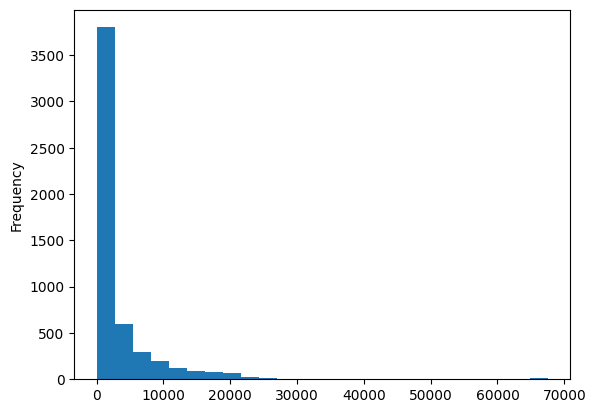

In [27]:

junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 300   )  ), 'duration(s)'].plot(kind='hist', bins = 25);

##### Casos para corte dos passageiros validos

- Ha casos em que a duracao conexao de um passageiro eh superior a 47000 segundos (12h)
    - isso ocorre para passageiros que usam a linha diariamente
    - assim a dataInicio ocorre no fim de um dia e a dataFim no inicio de outro
- Com isso deve-se faze rum corte para retirar essas anomalia

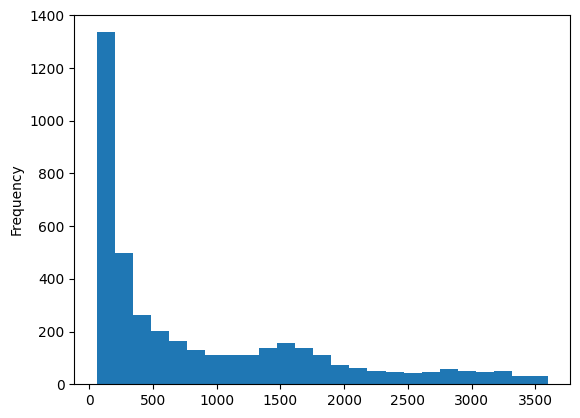

In [28]:
junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 300   )  ), 'duration(s)'].plot(kind='hist', bins = 25);

#### Histograma Distance 
    - entre um minuto e uma hora de viagem
    - pelo menos 300m percorridos

##### Conclusao: Absoluta concentracao viagens de curta ducarao (ate 10 minutos)

    - 95% percentil de viagens é de 2km
    - Sao 230 viagens com mais de 2km, razoavel retirar sujeira

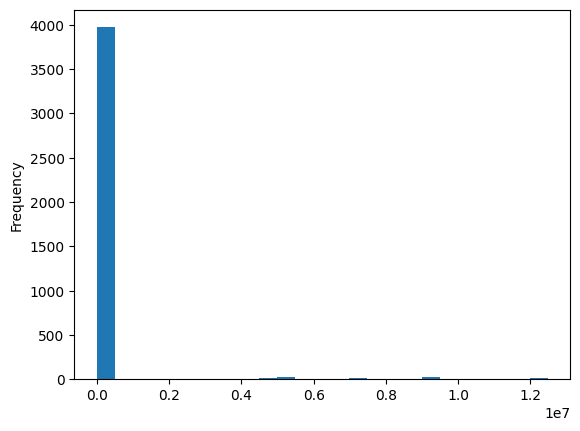

In [29]:

junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 300   )  ), 'distance(m)'].plot(kind='hist', bins = 25);

In [30]:

junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 300   )  ), 'distance(m)'].describe(percentiles=[ .25, .5, .75, .80, .85, .90, .95])
# sao 4030

count    4.066000e+03
mean     1.596414e+05
std      1.131259e+06
min      3.000165e+02
25%      4.261115e+02
50%      6.060513e+02
75%      9.625919e+02
80%      1.101657e+03
85%      1.282900e+03
90%      1.578465e+03
95%      2.141612e+03
max      1.248289e+07
Name: distance(m), dtype: float64

In [31]:

junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 2000   )  ) ]

,day,device_id,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
14,1,14,2021-06-01 07:58:19,2021-06-01 18:10:06,10,2.316922e+03,2644.0,-22.826920,-47.061282,-22.813783,-47.070272
143,1,143,2021-06-01 07:38:07,2021-06-01 19:09:18,13,2.003826e+03,2336.0,-22.825901,-47.067447,-22.827559,-47.067233
168,1,168,2021-06-01 07:38:59,2021-06-01 07:43:08,1,5.073419e+06,249.0,-22.829313,-47.065591,22.825704,-47.066347
219,1,219,2021-06-01 07:41:22,2021-06-01 17:03:53,3,2.376850e+03,830.0,-22.829499,-47.063892,-22.831503,-47.063166
382,1,382,2021-06-01 07:51:01,2021-06-01 19:22:27,14,3.006724e+03,1775.0,-22.813717,-47.060353,-22.815985,-47.062549
...,...,...,...,...,...,...,...,...,...,...,...
119526,30,400,2021-06-30 09:27:48,2021-06-30 17:18:56,7,5.071291e+06,234.0,-22.814552,-47.057213,-22.814391,-47.058259
119677,30,801,2021-06-30 09:06:08,2021-06-30 14:30:28,4,2.225460e+03,2284.0,-22.816233,-47.072673,-22.816320,-47.072668
119756,30,1103,2021-06-30 07:49:07,2021-06-30 17:19:23,9,5.071677e+06,638.0,-22.814323,-47.058529,-22.813752,-47.059717
120511,30,10848,2021-06-30 07:35:25,2021-06-30 18:41:20,11,5.073102e+06,3578.0,-22.824826,-47.065397,-22.825081,-47.065882


In [32]:

junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 2000   )  ), 'distance(m)'].describe(percentiles=[ .25, .5, .75, .80, .85, .90, .95])
# sao 4030

count    2.320000e+02
mean     2.786193e+06
std      3.895166e+06
min      2.002638e+03
25%      2.330310e+03
50%      2.964286e+03
75%      5.072819e+06
80%      5.708661e+06
85%      7.209660e+06
90%      9.434119e+06
95%      9.438754e+06
max      1.248289e+07
Name: distance(m), dtype: float64

### Passageiros Validos

Foi adotado a duracao das viagens entre 60s e 1h

e com distancia percorrida entre 300m e 2,125km



In [33]:
validas_junho = junho_coordenadas.loc[  ((  junho_coordenadas['duration(s)'] > 60   ) & (  junho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  junho_coordenadas['distance(m)'] > 300  ) & (  junho_coordenadas['distance(m)'] < 2125   )  )]


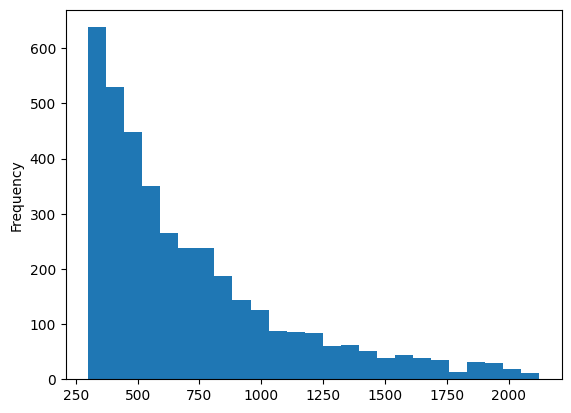

In [34]:
validas_junho['distance(m)'].plot(kind='hist', bins = 25);

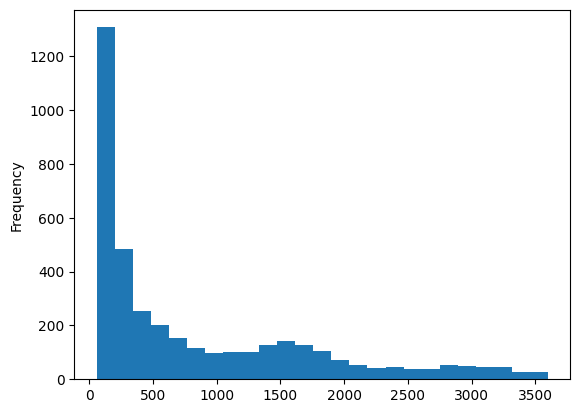

In [35]:
validas_junho['duration(s)'].plot(kind='hist', bins = 25);

In [36]:
paradas_inicial = pd.read_excel("Dados brutos/PontosEletrico.xlsx")
paradas_inicial.rename(columns={'Ponto': 'PontoInicial'}, inplace = True)
paradas_final = pd.read_excel("Dados brutos/PontosEletrico.xlsx")
paradas_final.rename(columns={'Ponto': 'PontoFinal'}, inplace = True)
paradas_final

,PontoFinal,Lat,Long
0,1,-22.816277,-47.072980
1,2,-22.813869,-47.071639
2,3,-22.813622,-47.069654
3,4,-22.813810,-47.069311
4,5,-22.812524,-47.067208
5,6,-22.814839,-47.066822
6,7,-22.816629,-47.066028
7,8,-22.813401,-47.065131
8,9,-22.814806,-47.064200
9,10,-22.818229,-47.066136


In [37]:
paradas_eletrico_inicio = pd.read_excel("Dados brutos/PontosEletrico.xlsx")
paradas_eletrico_inicio.rename(columns={'Ponto': 'PontoInicial'}, inplace = True)
paradas_eletrico_final= pd.read_excel("Dados brutos/PontosEletrico.xlsx")
paradas_eletrico_final.rename(columns={'Ponto': 'PontoFinal'}, inplace = True)
paradas_eletrico_final


,PontoFinal,Lat,Long
0,1,-22.816277,-47.072980
1,2,-22.813869,-47.071639
2,3,-22.813622,-47.069654
3,4,-22.813810,-47.069311
4,5,-22.812524,-47.067208
5,6,-22.814839,-47.066822
6,7,-22.816629,-47.066028
7,8,-22.813401,-47.065131
8,9,-22.814806,-47.064200
9,10,-22.818229,-47.066136


In [38]:
junho = pd.read_excel('viagens_validas_junho.xlsx', index_col='Unnamed: 0')
junho.rename(columns={'index': 'index_col'}, inplace = True)
junho.loc[junho.dataInicio.dt.month == 6, 'index_col'] = junho['index_col'].astype(str) + '_' + junho.dataInicio.dt.month.astype(str)

julho = pd.read_excel('viagens_validas_julho.xlsx', index_col='Unnamed: 0')
julho.rename(columns={'index': 'index_col'}, inplace = True)
julho.loc[julho.dataInicio.dt.month == 7, 'index_col'] = julho['index_col'].astype(str) + '_' + julho.dataInicio.dt.month.astype(str)

agosto = pd.read_excel('viagens_validas_agosto.xlsx', index_col='Unnamed: 0')
agosto.rename(columns={'index': 'index_col'}, inplace = True)
agosto.loc[agosto.dataInicio.dt.month == 8, 'index_col'] = agosto['index_col'].astype(str) + '_' + agosto.dataInicio.dt.month.astype(str)

viagens_validas = pd.concat([junho, julho, agosto], axis = 0)

viagens_validas

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6010,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6011,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6012,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6013,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243


In [39]:
gpd1 = gpd.GeoDataFrame(viagens_validas, geometry=gpd.points_from_xy(viagens_validas.longitudeI, viagens_validas.latitudeI))
gpd2 = gpd.GeoDataFrame(paradas_eletrico_inicio, geometry=gpd.points_from_xy(paradas_eletrico_inicio.Long, paradas_eletrico_inicio.Lat))


def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

gpd3=ckdnearest(gpd1, gpd2)
gpd3


,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,geometry,PontoInicial,Lat,Long,dist
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,POINT (-47.06142 -22.82678),39(PONTOFINAL),-22.827112,-47.061369,0.000339
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,POINT (-47.06137 -22.82689),39(PONTOFINAL),-22.827112,-47.061369,0.000222
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,POINT (-47.06104 -22.82762),38(PONTOINICIAL),-22.827196,-47.061327,0.000510
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,POINT (-47.06122 -22.82708),39(PONTOFINAL),-22.827112,-47.061369,0.000153
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,POINT (-47.06011 -22.81379),28,-22.813965,-47.058839,0.001283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06603 -22.82888),23,-22.828808,-47.066226,0.000209
16542,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06603 -22.82888),23,-22.828808,-47.066226,0.000209
16543,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06603 -22.82888),23,-22.828808,-47.066226,0.000209
16544,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,POINT (-47.06391 -22.83102),34,-22.831662,-47.063050,0.001074


In [40]:
gpd4 = gpd.GeoDataFrame(viagens_validas, geometry=gpd.points_from_xy(viagens_validas.longitudeF, viagens_validas.latitudeF))
gpd5 = gpd.GeoDataFrame(paradas_eletrico_final, geometry=gpd.points_from_xy(paradas_eletrico_final.Long, paradas_eletrico_final.Lat))


def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

gpd6=ckdnearest(gpd4, gpd5)
gpd6


,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,geometry,PontoFinal,Lat,Long,dist
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,POINT (-47.06069 -22.82971),36,-22.829614,-47.061370,0.000691
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,POINT (-47.06131 -22.82710),39(PONTOFINAL),-22.827112,-47.061369,0.000065
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,POINT (-47.06059 -22.82889),36,-22.829614,-47.061370,0.001064
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,POINT (-47.06056 -22.82892),36,-22.829614,-47.061370,0.001067
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,POINT (-47.06219 -22.83178),34,-22.831662,-47.063050,0.000868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06697 -22.82776),26,-22.827839,-47.066777,0.000213
16542,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06697 -22.82776),26,-22.827839,-47.066777,0.000213
16543,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,POINT (-47.06697 -22.82776),26,-22.827839,-47.066777,0.000213
16544,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,POINT (-47.06524 -22.82499),20,-22.825058,-47.066254,0.001013


In [41]:
matriz_junho= pd.merge(gpd6, gpd3,how = 'inner' , on = ['index_col','day', 'device_id', 'periodo', 'sequence', 'distance(m)', 'duration(s)', 'dataInicio', 'dataFim','latitudeI', 'longitudeI', 'latitudeF', 'longitudeF'])
matriz_junho = matriz_junho[['index_col','day', 'device_id', 'periodo', 'dataInicio', 'dataFim', 'sequence', 'distance(m)',
       'duration(s)', 'latitudeI', 'longitudeI', 'latitudeF', 'longitudeF',
        'PontoFinal',  'dist_x','PontoInicial', 'dist_y']]

matriz_junho

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,PontoFinal,dist_x,PontoInicial,dist_y
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,36,0.000691,39(PONTOFINAL),0.000339
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,39(PONTOFINAL),0.000065,39(PONTOFINAL),0.000222
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,36,0.001064,38(PONTOINICIAL),0.000510
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,36,0.001067,39(PONTOFINAL),0.000153
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,34,0.000868,28,0.001283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,26,0.000213,23,0.000209
16542,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,26,0.000213,23,0.000209
16543,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,26,0.000213,23,0.000209
16544,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,20,0.001013,34,0.001074


In [42]:
matriz_junho_agrupada=matriz_junho.groupby(by=[matriz_junho.dataInicio.dt.month,matriz_junho.day, matriz_junho.periodo,'PontoInicial','PontoFinal']).agg({'sequence': 'count'}).reset_index()

matriz_junho_agrupada

,dataInicio,day,periodo,PontoInicial,PontoFinal,sequence
0,6,1,Manha,1,2,2
1,6,1,Manha,1,17,1
2,6,1,Manha,1,20,2
3,6,1,Manha,2,4,1
4,6,1,Manha,4,4,2
...,...,...,...,...,...,...
9303,8,31,Tarde,34,34,2
9304,8,31,Tarde,34,36,1
9305,8,31,Tarde,36,23,1
9306,8,31,Tarde,36,37,3


In [43]:
pivotttt = matriz_junho_agrupada[(matriz_junho_agrupada['dataInicio'] == 6) &
                                 (matriz_junho_agrupada['day'] == 1) &
                                 (matriz_junho_agrupada['periodo'] == 'Tarde')].pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)
pivotttt

PontoFinal,1,2,4,6,8,9,10,16,17,19,...,23,24,25,26,28,32,34,36,37,38(PONTOINICIAL)
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Resolvendo o p-Medianas

In [104]:
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster import cluster_visualizer

In [105]:
matriz_junho


,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,PontoFinal,dist_x,PontoInicial,dist_y
0,0_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,36,0.000691,39(PONTOFINAL),0.000339
1,1_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,39(PONTOFINAL),0.000065,39(PONTOFINAL),0.000222
2,2_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,36,0.001064,38(PONTOINICIAL),0.000510
3,3_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,36,0.001067,39(PONTOFINAL),0.000153
4,4_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,34,0.000868,28,0.001283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,26,0.000213,23,0.000209
16542,6011_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,26,0.000213,23,0.000209
16543,6012_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,26,0.000213,23,0.000209
16544,6013_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,20,0.001013,34,0.001074


In [106]:
paradas_eletrico_final.head(10)

,PontoFinal,Lat,Long,geometry
0,1,-22.816277,-47.072980,POINT (-47.07298 -22.81628)
1,2,-22.813869,-47.071639,POINT (-47.07164 -22.81387)
2,3,-22.813622,-47.069654,POINT (-47.06965 -22.81362)
3,4,-22.813810,-47.069311,POINT (-47.06931 -22.81381)
4,5,-22.812524,-47.067208,POINT (-47.06721 -22.81252)
5,6,-22.814839,-47.066822,POINT (-47.06682 -22.81484)
6,7,-22.816629,-47.066028,POINT (-47.06603 -22.81663)
7,8,-22.813401,-47.065131,POINT (-47.06513 -22.81340)
8,9,-22.814806,-47.064200,POINT (-47.06420 -22.81481)
9,10,-22.818229,-47.066136,POINT (-47.06614 -22.81823)


In [ ]:
# kmedians.__init__	(	 	self, 	data, 	initial_centers, 	tolerance = 0.001, 	ccore = True, 	kwargs )		

# [in]	data	(list): Input data that is presented as list of points (objects), each point should be represented by list or tuple.
# [in]	initial_centers	(list): Initial coordinates of medians of clusters that are represented by list: [center1, center2, ...].
# [in]	tolerance	(double): Stop condition: if maximum value of change of centers of clusters is less than tolerance than algorithm will stop processing
# [in]	ccore	(bool): Defines should be CCORE library (C++ pyclustering library) used instead of Python code or not.
# [in]	**kwargs	Arbitrary keyword arguments (available arguments: 'metric', 'itermax').

# print(kmedians_instance)

In [114]:
def apply_kmedians(latlong_paradas, latlong_viagens):
    kmedians_instance = kmedians(latlong_viagens, latlong_paradas)
    kmedians_instance.process()
    viagens_por_parada = kmedians_instance.get_clusters()
    pontos_parada = kmedians_instance.get_medians()

    return pontos_parada, viagens_por_parada


In [107]:
pontos_parada_antes = paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].isin([i for i in range(8)]), ['Lat','Long']].values.tolist()
paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].isin([i for i in range(8)])]

,PontoFinal,Lat,Long,geometry
0,1,-22.816277,-47.072980,POINT (-47.07298 -22.81628)
1,2,-22.813869,-47.071639,POINT (-47.07164 -22.81387)
2,3,-22.813622,-47.069654,POINT (-47.06965 -22.81362)
3,4,-22.813810,-47.069311,POINT (-47.06931 -22.81381)
4,5,-22.812524,-47.067208,POINT (-47.06721 -22.81252)
5,6,-22.814839,-47.066822,POINT (-47.06682 -22.81484)
6,7,-22.816629,-47.066028,POINT (-47.06603 -22.81663)


In [108]:
pontos_viagens = matriz_junho.loc[matriz_junho['day'] == 1, ['latitudeI','longitudeI']].values.tolist()

In [110]:
pontos_parada, viagens_por_parada = apply_kmedians(pontos_parada_antes, pontos_viagens)

In [109]:
print(len(clusters))
for num in range(len(clusters)):
    
    print(num, len(clusters[num]), '\n',clusters[num])

7
0 18 
 [10, 11, 112, 113, 114, 115, 144, 272, 274, 293, 308, 315, 318, 324, 325, 337, 340, 341]
1 6 
 [116, 168, 271, 292, 307, 351]
2 2 
 [306, 321]
3 3 
 [88, 89, 111]
4 1 
 [143]
5 14 
 [60, 61, 80, 82, 87, 241, 242, 263, 266, 287, 288, 298, 326, 360]
6 319 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 83, 84, 85, 86, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 

IndexError: list index out of range

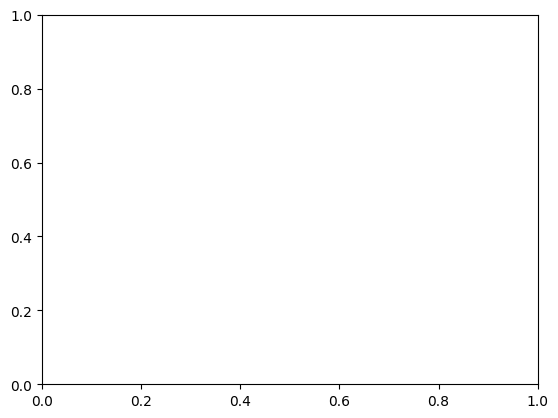

In [84]:

# Visualize clustering results.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, pontos_onibus)
# visualizer.show()
visualizer.append_cluster(pontos_onibus, marker='*', markersize=10)
# visualizer.show()
visualizer.append_cluster(medians, marker='*', markersize=10)
visualizer.show()